In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
%pylab inline
import pytorch_lightning as pl
from pytorch_lightning.callbacks import Callback

# Set a bigger default plot size
mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['font.size'] = 16

Populating the interactive namespace from numpy and matplotlib


## Example model & dataloader

In [2]:
from hydrogen_pg.dataloaders.taylor_example_dataloader import Conv2dDataModule
from hydrogen_pg.models.taylor_example_model import RMM_NN_2D_B1
from hydrogen_pg.utils.callbacks import MetricsCallback

In [3]:
in_vars = ['precipitation', 'temperature', 'slope_x', 'slope_y', 'saturation']
out_vars = ['saturation']

pfmeta_file = '/hydrodata/PFCLM/Taylor/Simulations/1990/Taylor_1990.out.pfmetadata'

# Surface saturation
z_strategy = -1
dataloader = Conv2dDataModule(pfmeta_file, 
                              in_vars=in_vars, 
                              out_vars=out_vars, 
                              z_strategy=z_strategy)

In [4]:
model = RMM_NN_2D_B1(grid_size=dataloader.shape,
                     in_vars=in_vars,
                     out_vars=out_vars)
model.configure_optimizers()
model.configure_loss()

/home/ab6361/software/miniconda/envs/all/lib/python3.9/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


## Validate dataloader and model can operate together

Perhaps this goes in `utils` as `validate(model, dataloader)`

In [5]:
data_shape  = dataloader.shape
data_in_features, data_out_features = dataloader.feature_names
model_shape = model.shape
model_in_features, model_out_features = model.feature_names

assert data_shape == model_shape
assert data_in_features == model_in_features
assert data_out_features == model_out_features

In [6]:
metrics = MetricsCallback()
trainer = pl.Trainer(max_epochs=10, gpus=1, callbacks=[metrics])
trainer.fit(model, dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/ab6361/software/miniconda/envs/all/lib/python3.9/site-packages/pytorch_lightning/core/memory.py:483: UserWarning: A layer with UninitializedParameter was found. Thus, the total number of parameters detected may be inaccurate.
  warning_cache.warn(

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 14.8 M
-------------------------------------
14.8 M    Trainable params
0         Non-trainable params
14.8 M    Total params
59.231    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/ab6361/software/miniconda/envs/all/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 96 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/ab6361/software/miniconda/envs/all/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /tmp/pip-req-build-19kunu9c/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/home/ab6361/software/miniconda/envs/all/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, trai

Training: -1it [00:00, ?it/s]

/home/ab6361/workspace/hydrogen_infrastructure_playground/hydrogen_pg/models/taylor_example_model.py:94: UserWarning: Using a target size (torch.Size([256, 1, 47, 45])) that is different to the input size (torch.Size([256, 47, 45])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = self.loss_fun(y_hat, y)
/home/ab6361/workspace/hydrogen_infrastructure_playground/hydrogen_pg/models/taylor_example_model.py:94: UserWarning: Using a target size (torch.Size([243, 1, 47, 45])) that is different to the input size (torch.Size([243, 47, 45])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = self.loss_fun(y_hat, y)


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

(0.005, 0.02)

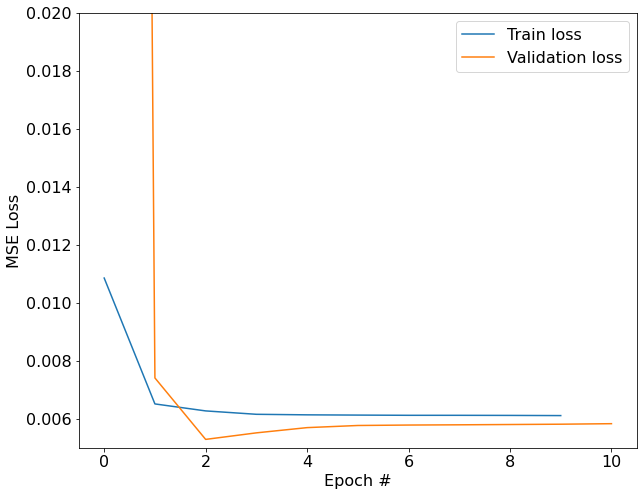

In [10]:
plt.plot(metrics.metrics['train_loss'], label='Train loss')
plt.plot(metrics.metrics['val_loss'], label='Validation loss')
plt.legend()
plt.xlabel('Epoch #')
plt.ylabel('MSE Loss')
plt.ylim([0.005, 0.02])

In [28]:
val_x, val_y = next(iter(dataloader.val_dataloader()))
val_x = val_x[0:1]
val_y = val_y[0:1].squeeze().cpu().detach().numpy()

val_yhat = model(val_x)
val_yhat = val_yhat.squeeze().cpu().detach().numpy()
err = val_y - val_yhat

Text(0.5, 1.0, 'Error')

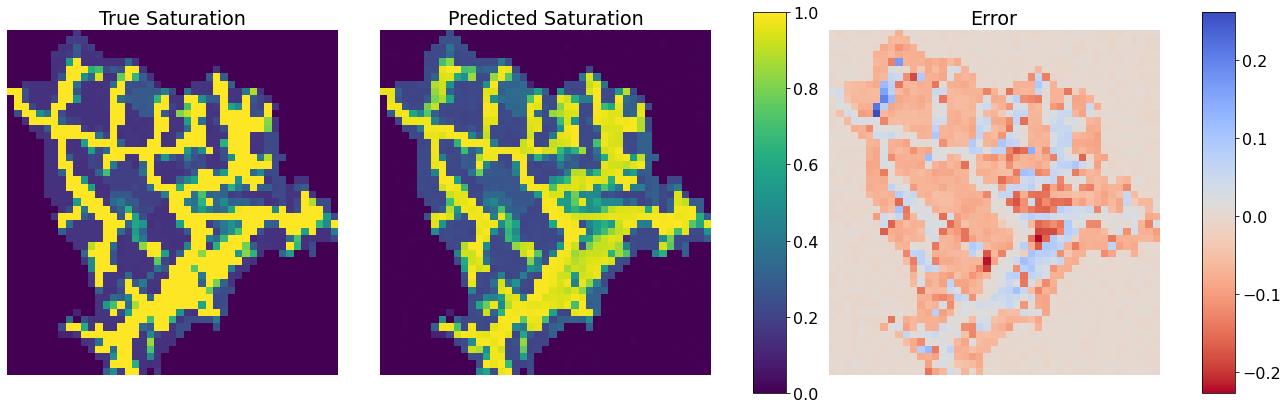

In [63]:
fig, axes = plt.subplots(1, 5, figsize=(22, 7),
                         gridspec_kw={'width_ratios': [1, 1, 0.1, 1, 0.1], 'height_ratios': [1]})

sm = axes[0].imshow(val_y, vmin=0, vmax=1)
axes[1].imshow(val_yhat, vmin=0, vmax=1)
plt.colorbar(sm, cax=axes[2])
sm = axes[3].imshow(err, cmap='coolwarm_r')
plt.colorbar(sm, cax=axes[-1])

for ax in axes[[0,1,3]]:
    ax.axis('off')
axes[0].set_title('True Saturation')
axes[1].set_title('Predicted Saturation')
axes[3].set_title('Error')